In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [6]:
X_test = pd.read_csv('saved_datasets/X_test.csv')
X_train = pd.read_csv('saved_datasets/X_train.csv')
X_val = pd.read_csv('saved_datasets/X_val.csv')
y_test = pd.read_csv('saved_datasets/y_test.csv')
y_train = pd.read_csv('saved_datasets/y_train.csv')
y_val = pd.read_csv('saved_datasets/y_val.csv')

In [7]:
X_val.head()

product_id  add_to_cart_order  user_id  order_number  \
0        7649                  9      210            63   
1       33731                 14      462            54   
2       43086                  4      465            12   
3       28204                  3     1866            18   
4       13263                  7     1072            15   

   days_since_prior_order  avg_days_since_prior_order  total_orders  \
0                     3.0                    3.221311           100   
1                     7.0                    5.718750            59   
2                     1.0                    9.378378            41   
3                     4.0                    4.044944            97   
4                     6.0                    7.100000            15   

   avg_products  order_dow_0  order_dow_1  ...  department_pets  \
0      8.868852        False        False  ...            False   
1     10.696970        False        False  ...            False   
2      8.756757        False         True  ...            False   
3      4.648352        False        False  ...            False   
4      8.050000        False         True  ...            False   

   department_produce  department_snacks  most_common_order_dow_0  \
0               False              False                     True   
1               False              False                    False   
2                True              False                    False   
3                True              False                    False   
4               False              False                    False   

   most_common_order_dow_1  most_common_order_dow_2  most_common_order_dow_3  \
0                    False                    False                    False   
1                     True                    False                    False   
2                    False                    False                    False   
3                    False                    False                    False   
4                     True                    False                    False   

   most_common_order_dow_4  most_common_order_dow_5  most_common_order_dow_6  
0                    False                    False                    False  
1                    False                    False                    False  
2                    False                     True                    False  
3                    False                     True                    False  
4                    False                    False                    False  

[5 rows x 181 columns]

In [8]:
y_val.head()

reordered
0          1
1          1
2          0
3          1
4          1

# Dealing with distribution shift

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution comparison for a given feature
def plot_distribution_comparison(feature, bins=30):
    plt.figure(figsize=(12, 6))
    sns.histplot(X_train[feature], color='blue', label='Train', bins=bins, kde=True, stat='density')
    sns.histplot(X_val[feature], color='green', label='Validation', bins=bins, kde=True, stat='density')
    sns.histplot(X_test[feature], color='red', label='Test', bins=bins, kde=True, stat='density')
    plt.legend()
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

# Plotting distribution comparison for 'days_since_prior_order'
plot_distribution_comparison('days_since_prior_order')


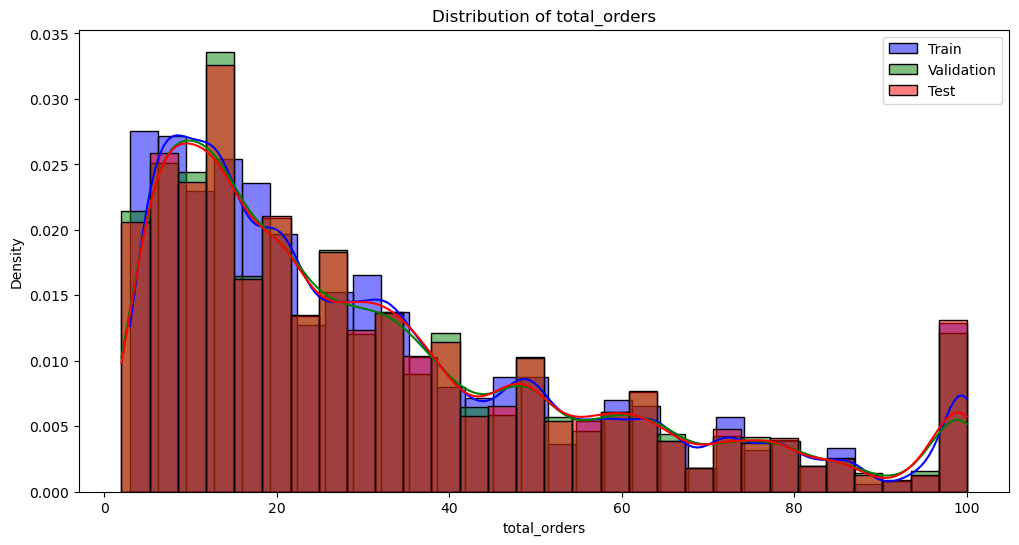

In [10]:
# Plotting distribution comparison for 'total_orders'
plot_distribution_comparison('total_orders')

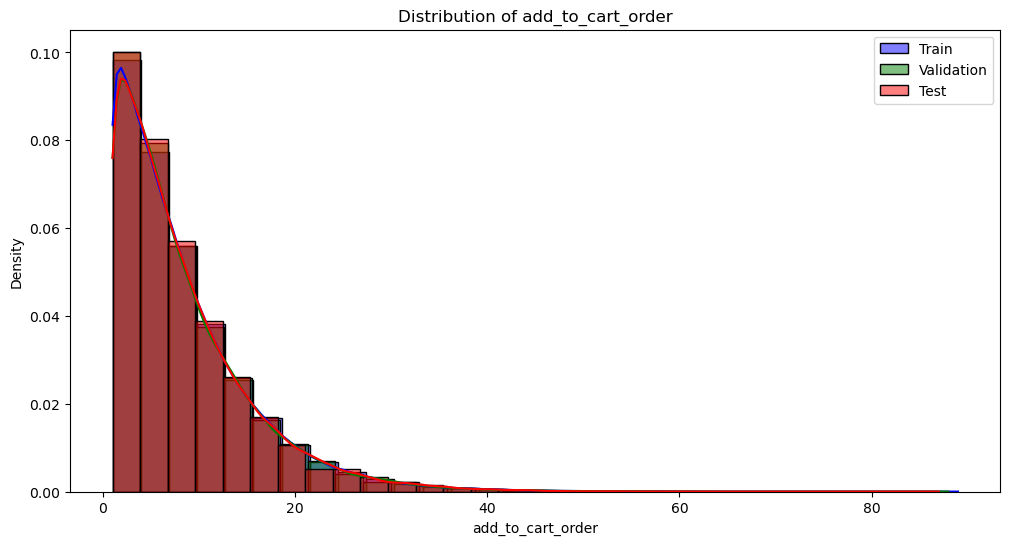

In [11]:
# Plotting distribution comparison for 'add_to_cart_order'
plot_distribution_comparison('add_to_cart_order')

In [12]:
# Plotting distribution comparison for 'order_number'
plot_distribution_comparison('order_number')

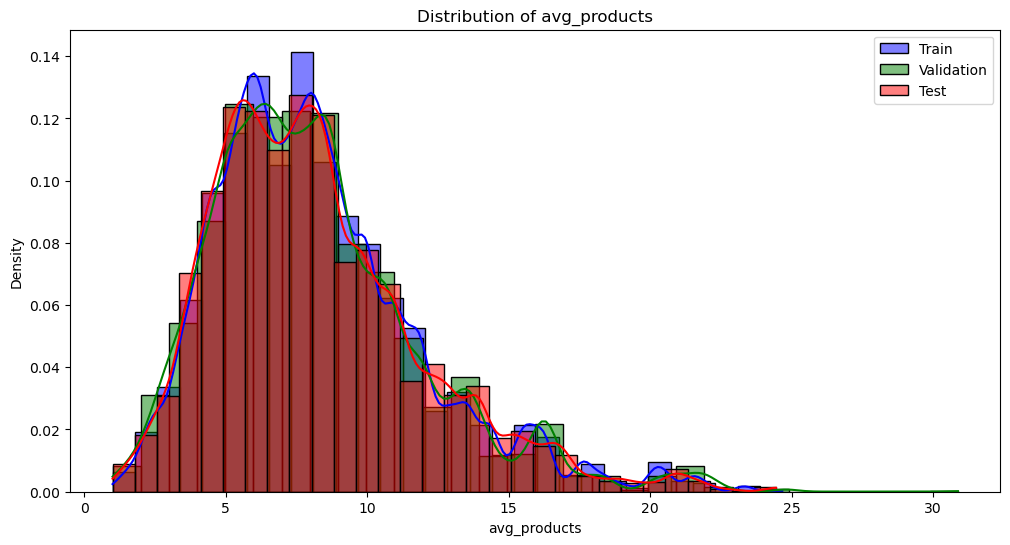

In [13]:
# Plotting distribution comparison for 'avg_products'
plot_distribution_comparison('avg_products')

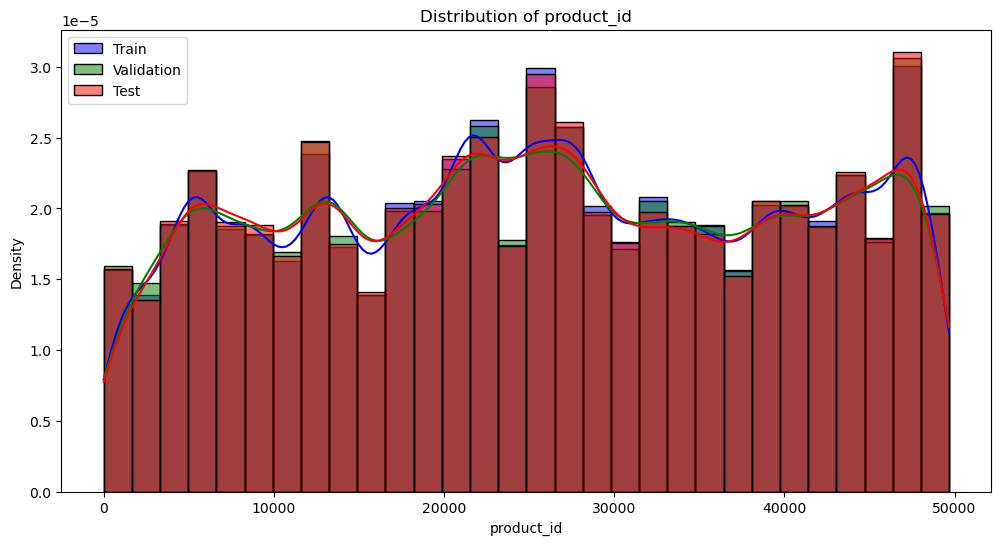

In [14]:
# Plotting distribution comparison for 'product_id'
plot_distribution_comparison('product_id')

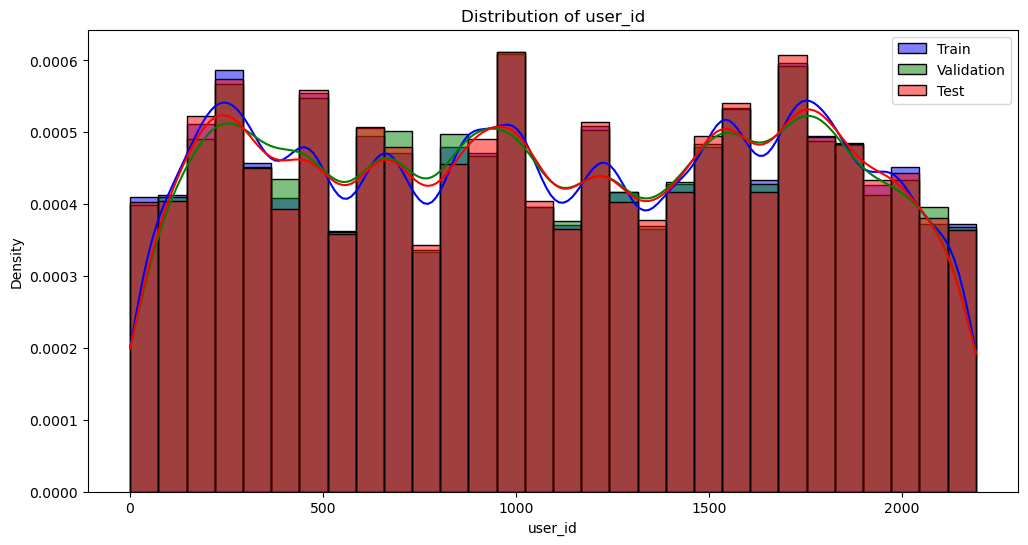

In [15]:
# Plotting distribution comparison for 'user_id'
plot_distribution_comparison('user_id')

In [16]:
from scipy.stats import ks_2samp

features = ['add_to_cart_order', 'order_number', 'days_since_prior_order', 'total_orders','product_id', 'user_id']

def compare_distributions(feature):
    stat, p_value = ks_2samp(X_train[feature], X_val[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Train and Validation: Statistic={stat:.4f}, P-value={p_value:.4f}")

    stat, p_value = ks_2samp(X_train[feature], X_test[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Train and Test: Statistic={stat:.4f}, P-value={p_value:.4f}")

for feature in features:
    compare_distributions(feature)



Kolmogorov-Smirnov test for add_to_cart_order between Train and Validation: Statistic=0.0062, P-value=0.0741
Kolmogorov-Smirnov test for add_to_cart_order between Train and Test: Statistic=0.0023, P-value=0.9431
Kolmogorov-Smirnov test for order_number between Train and Validation: Statistic=0.0017, P-value=0.9996
Kolmogorov-Smirnov test for order_number between Train and Test: Statistic=0.0039, P-value=0.3998
Kolmogorov-Smirnov test for days_since_prior_order between Train and Validation: Statistic=0.0044, P-value=0.3691
Kolmogorov-Smirnov test for days_since_prior_order between Train and Test: Statistic=0.0056, P-value=0.0811
Kolmogorov-Smirnov test for total_orders between Train and Validation: Statistic=0.0094, P-value=0.0010
Kolmogorov-Smirnov test for total_orders between Train and Test: Statistic=0.0063, P-value=0.0326
Kolmogorov-Smirnov test for product_id between Train and Validation: Statistic=0.0073, P-value=0.0188
Kolmogorov-Smirnov test for product_id between Train and Tes

In [17]:
# Downsample the train set to match the distribution of the validation set for 'total_orders'
train_indices = X_train['total_orders'].sample(n=len(X_val), random_state=42).index
X_train_resampled = X_train.loc[train_indices]
y_train_resampled = y_train.loc[train_indices]

from scipy.stats import ks_2samp

def compare_distributions_resampled(feature, X_train_resampled, X_val, X_test):
    stat, p_value = ks_2samp(X_train_resampled[feature], X_val[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Validation: Statistic={stat:.4f}, P-value={p_value:.4f}")

    stat, p_value = ks_2samp(X_train_resampled[feature], X_test[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Test: Statistic={stat:.4f}, P-value={p_value:.4f}")

compare_distributions_resampled('total_orders', X_train_resampled, X_val, X_test)


Kolmogorov-Smirnov test for total_orders between Resampled Train and Validation: Statistic=0.0111, P-value=0.0027
Kolmogorov-Smirnov test for total_orders between Resampled Train and Test: Statistic=0.0081, P-value=0.0379


In [18]:
# Downsample the train set to match the distribution of the validation set for 'product_id'
train_indices = X_train['product_id'].sample(n=len(X_val), random_state=42).index
X_train_resampled = X_train.loc[train_indices]
y_train_resampled = y_train.loc[train_indices]

from scipy.stats import ks_2samp

def compare_distributions_resampled(feature, X_train_resampled, X_val, X_test):
    stat, p_value = ks_2samp(X_train_resampled[feature], X_val[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Validation: Statistic={stat:.4f}, P-value={p_value:.4f}")

    stat, p_value = ks_2samp(X_train_resampled[feature], X_test[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Test: Statistic={stat:.4f}, P-value={p_value:.4f}")

compare_distributions_resampled('product_id', X_train_resampled, X_val, X_test)

Kolmogorov-Smirnov test for product_id between Resampled Train and Validation: Statistic=0.0048, P-value=0.5629
Kolmogorov-Smirnov test for product_id between Resampled Train and Test: Statistic=0.0038, P-value=0.7876


# Handling imbalanced datasets for the training data

In [19]:
import pandas as pd

class_distribution = y_train['reordered'].value_counts(normalize=True)
print(class_distribution)

reordered
1    0.583513
0    0.416487
Name: proportion, dtype: float64


In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert y_resampled to a numpy array
y_resampled_array = y_resampled.to_numpy().ravel()

# Convert y_resampled_array to a pandas Series
y_resampled_series = pd.Series(y_resampled_array)

class_distribution_resampled = y_resampled_series.value_counts(normalize=True)
print(class_distribution_resampled)


0    0.5
1    0.5
Name: proportion, dtype: float64


# Correlations

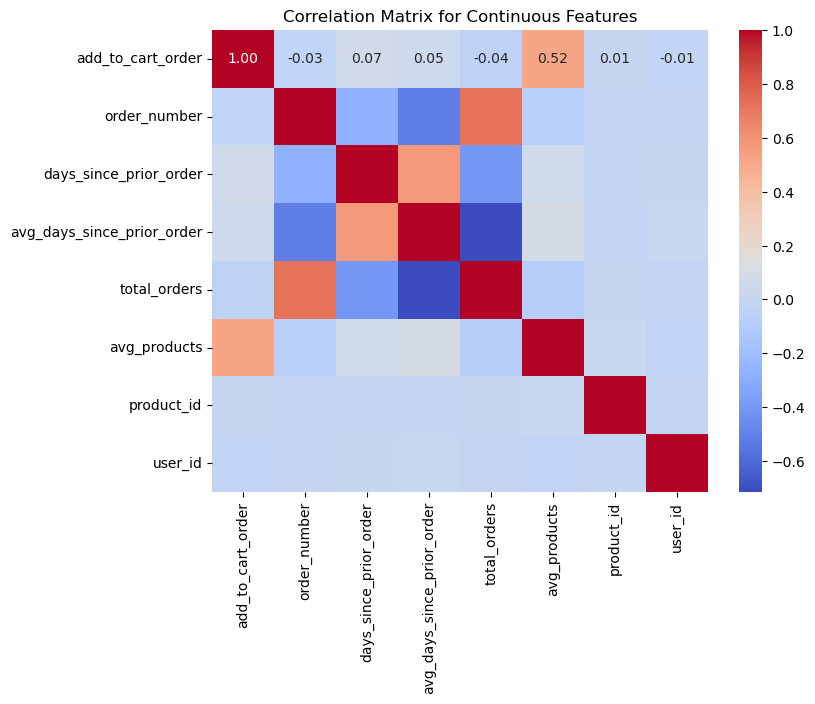

In [21]:
# Select continuous features
continuous_features = ['add_to_cart_order','order_number', 
                       'days_since_prior_order', 'avg_days_since_prior_order', 'total_orders', 'avg_products', 'product_id', 'user_id'] 

corr_continuous = X_train[continuous_features].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_continuous, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Continuous Features')
plt.show()


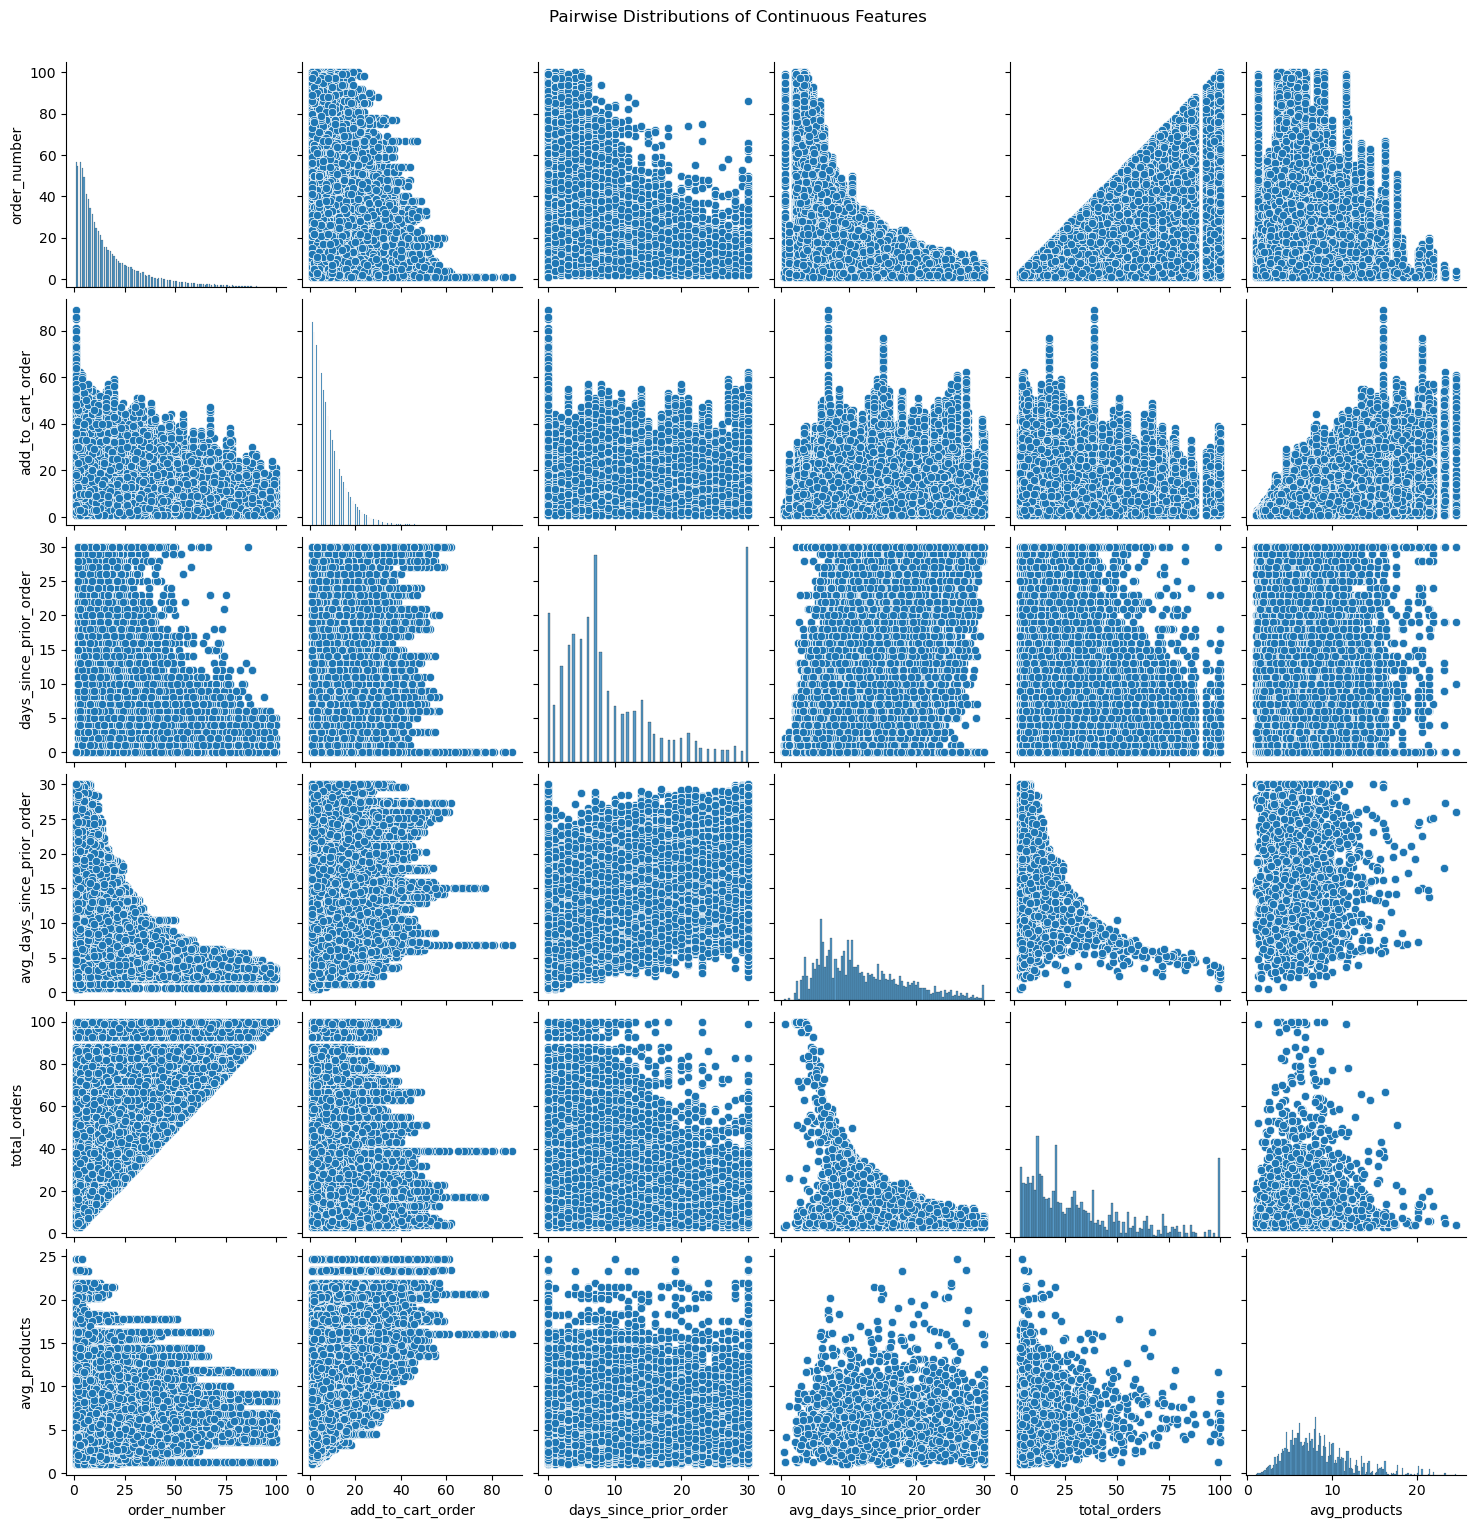

In [22]:
# pairplot to visualize pairwise relationships between the features
features = ['order_number', 'add_to_cart_order', 'days_since_prior_order', 'avg_days_since_prior_order', 'total_orders', 'avg_products']
sns.pairplot(X_train[features])
plt.suptitle('Pairwise Distributions of Continuous Features', y=1.02)
plt.show()


# Distributions

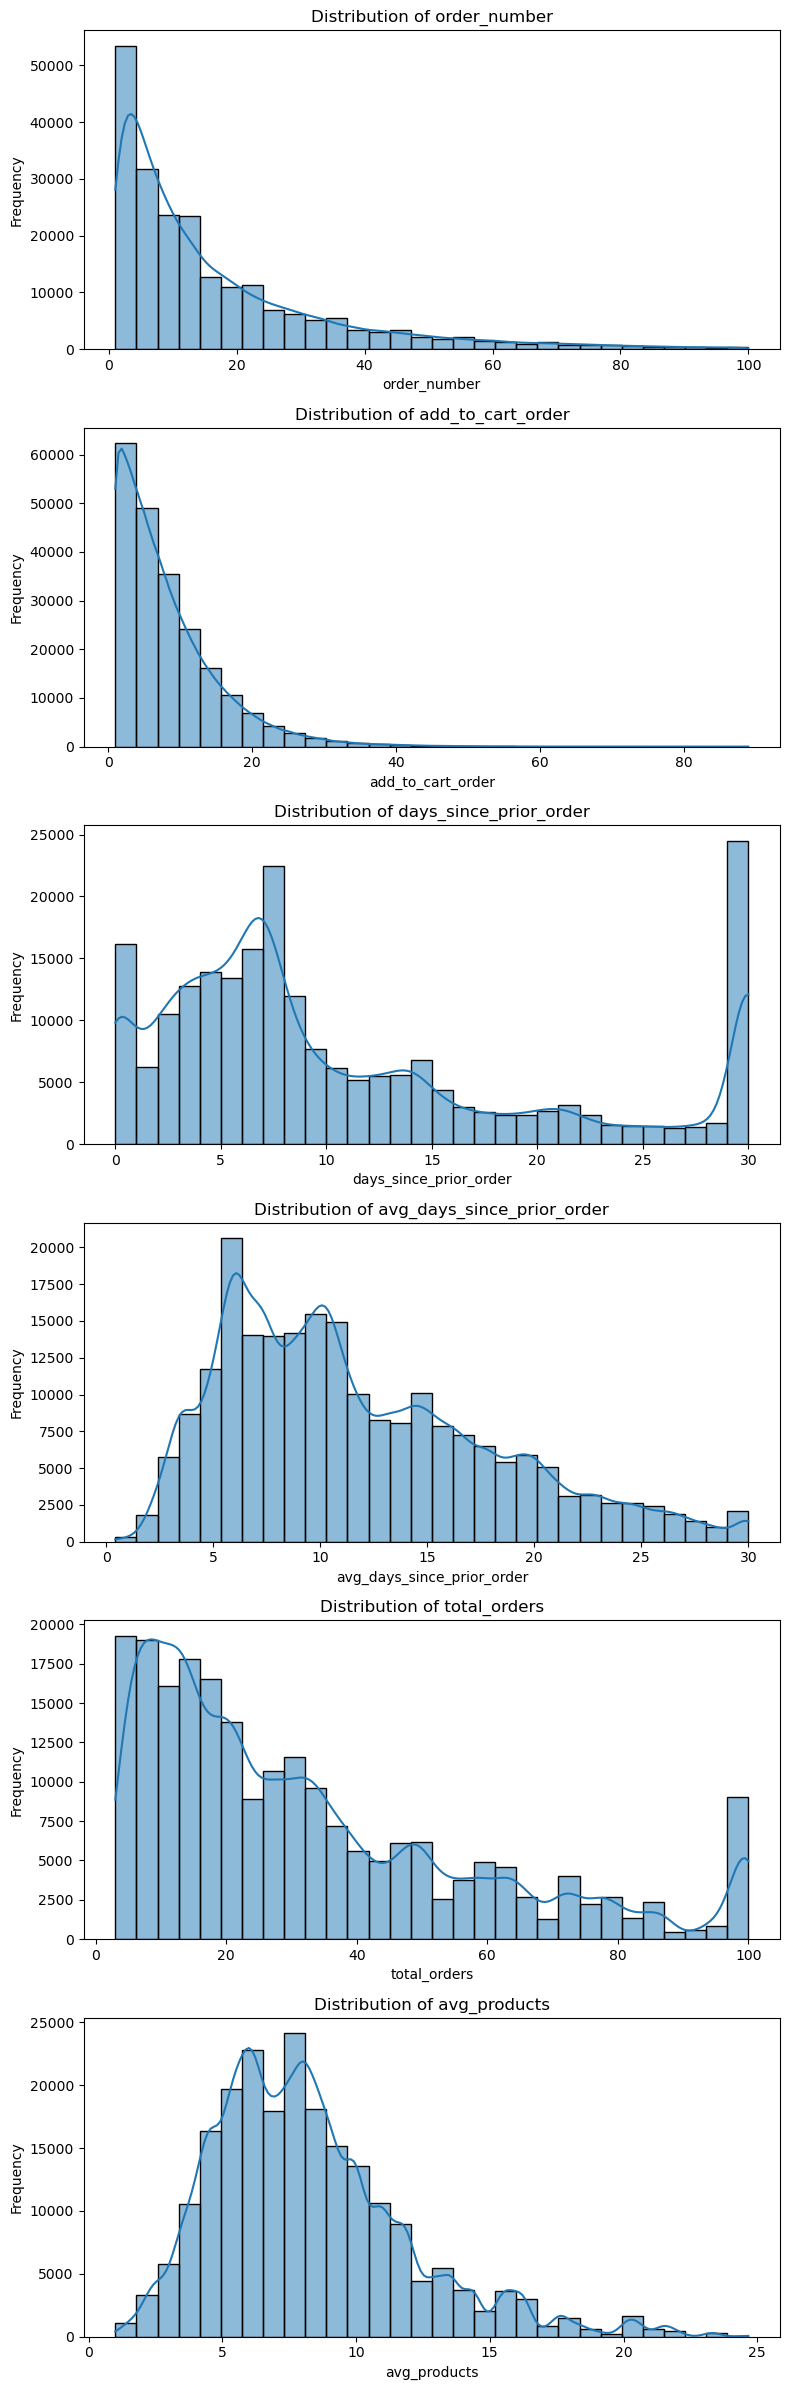

In [23]:
# Distribution of Features
n_features = len(features)
fig, axes = plt.subplots(n_features, 1, figsize=(8, 4 * n_features))

for i, feature in enumerate(features):
    sns.histplot(X_train[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# Densities

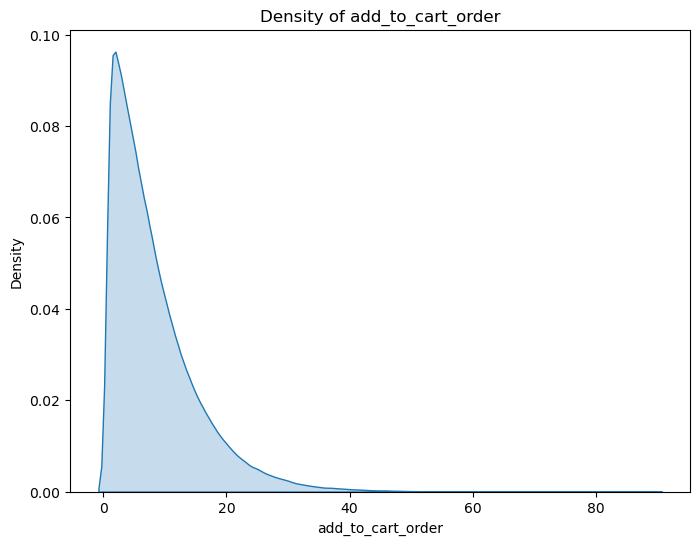

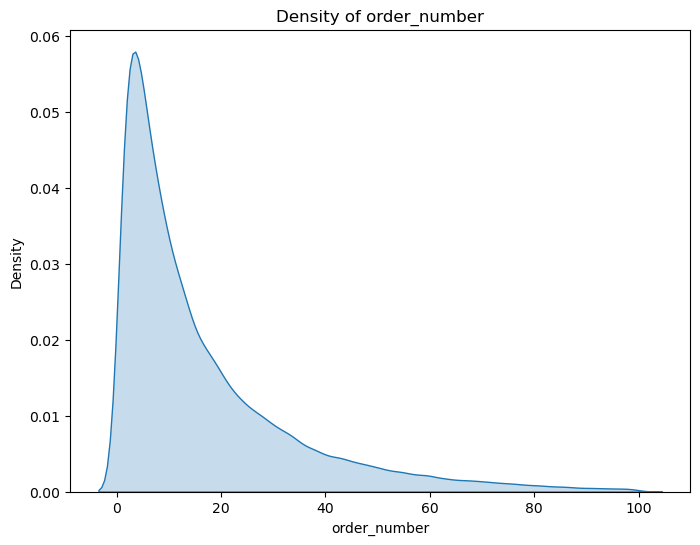

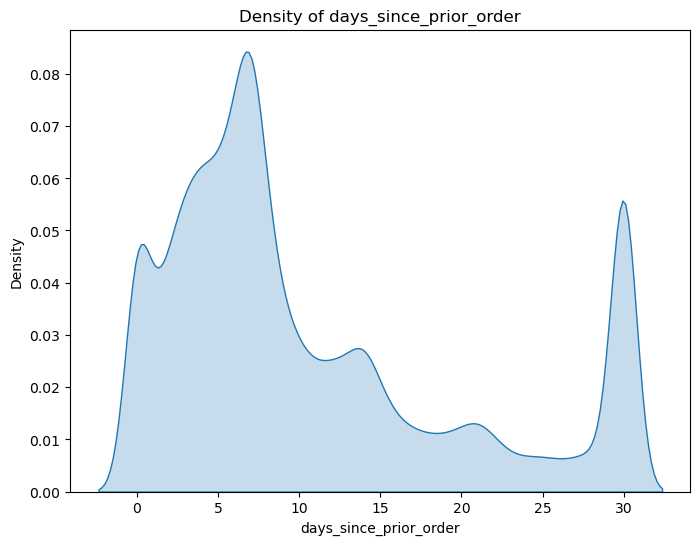

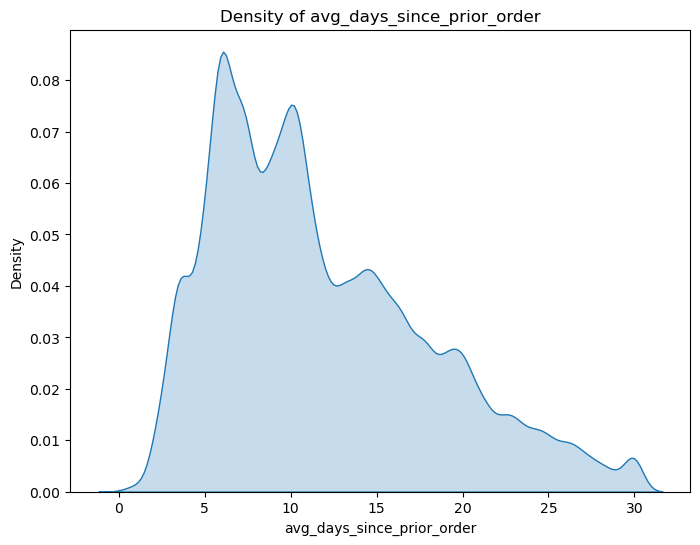

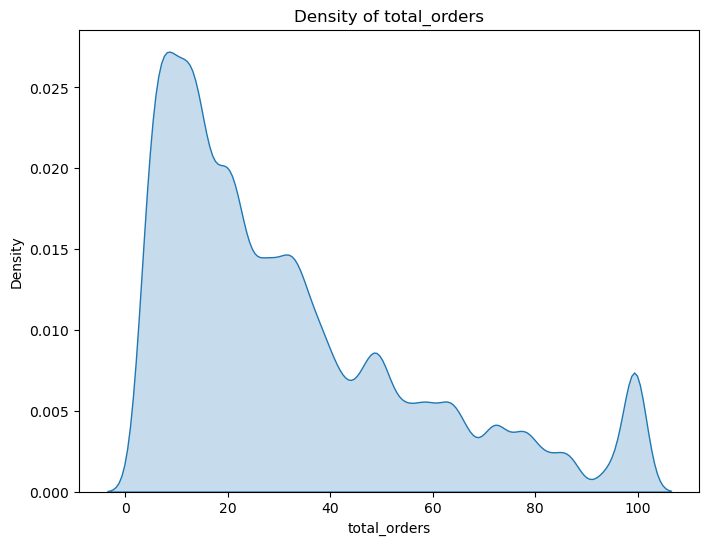

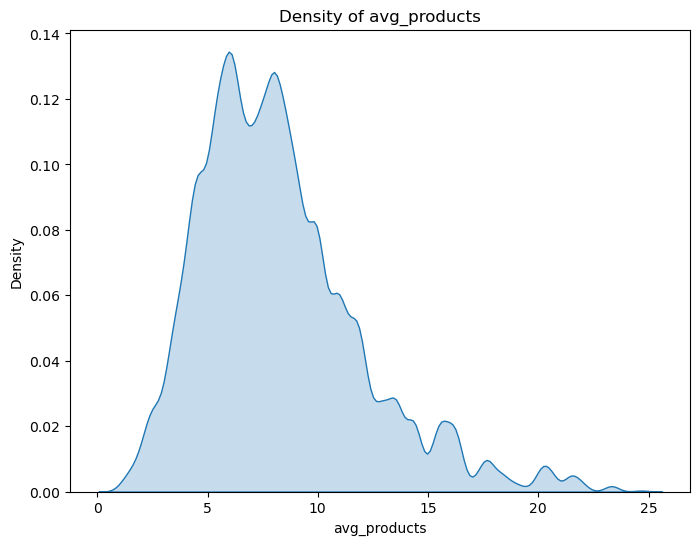

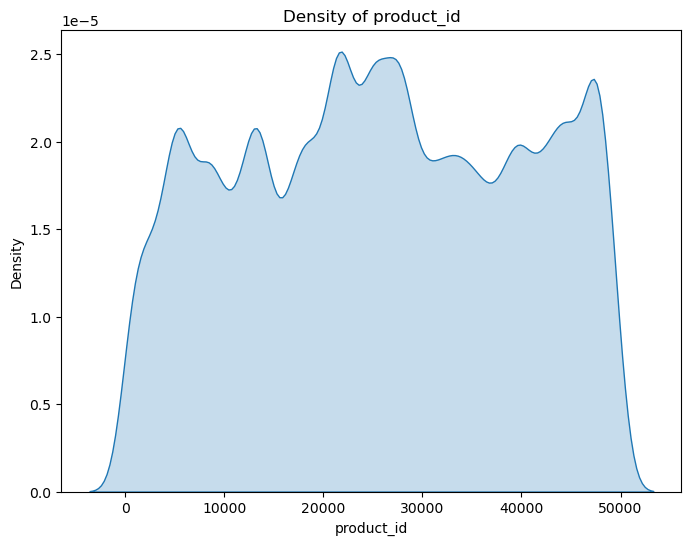

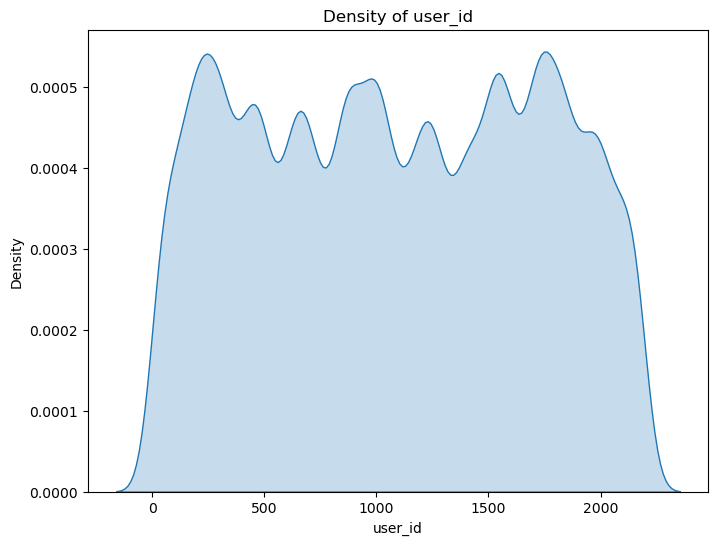

In [24]:
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(X_train[feature], shade=True)
    plt.title(f'Density of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


# Information Leakage Analysis

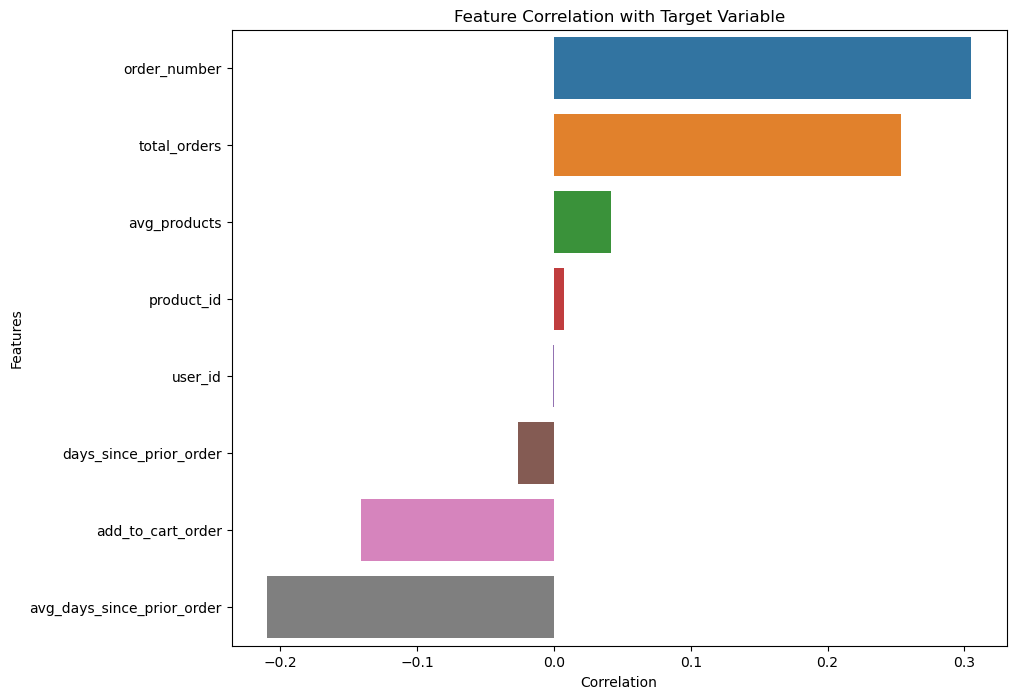

In [25]:
# Compute the correlation between features and the target variable
correlations = X_train[continuous_features].corrwith(y_train['reordered'])
correlations = correlations.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Feature Correlation with Target Variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()


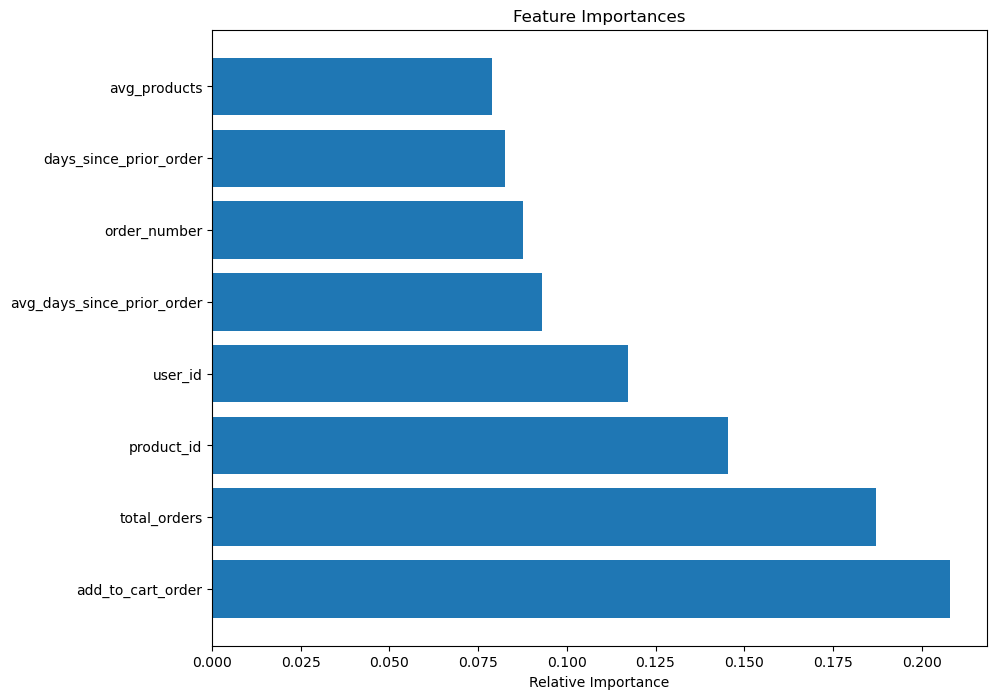

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[continuous_features], y_train['reordered'])

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### There are no features have surprisingly high importance score compared to our expectations. In addition, if there are features that are highly correlated with the target variable, that might be leaking information. Based on the output, we found that there are no features that are very highly correlated with the target variable. Therefore, by combining above results, there is no risk of imformation leakage.

## Feature Selection

In [27]:
X_train = X_resampled
y_train = y_resampled

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')  
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

print("X_train after imputation:\n", X_train)

X_train after imputation:
         product_id  add_to_cart_order  user_id  order_number  \
0          32611.0               12.0   2063.0           3.0   
1          37382.0               28.0    184.0          11.0   
2          34005.0                3.0    912.0           2.0   
3          41844.0               10.0   1990.0          31.0   
4          30427.0                6.0    236.0          42.0   
...            ...                ...      ...           ...   
252621     12576.0                6.0   1360.0           3.0   
252622     46431.0                7.0    776.0           1.0   
252623     38658.0               32.0   1137.0           2.0   
252624     23001.0                9.0   1180.0          11.0   
252625     14715.0                3.0    980.0           8.0   

        days_since_prior_order  avg_days_since_prior_order  total_orders  \
0                         21.0                   20.782609           4.0   
1                          4.0                   21.

### Feature selection : Lasso

In [32]:
from sklearn.linear_model import LassoLarsCV
import pandas as pd


model = LassoLarsCV(cv=5)

model.fit(X_train, y_train)

selected_features = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
selected_features = selected_features[selected_features['Coefficient'] != 0]

print("Selected Features:")
print(selected_features)


Selected Features:
                     Feature   Coefficient
0                 product_id  1.085745e-07
1          add_to_cart_order -1.470740e-02
2                    user_id  3.989729e-06
3               order_number  7.601543e-03
4     days_since_prior_order  6.733211e-03
..                       ...           ...
175  most_common_order_dow_1  1.785701e-02
176  most_common_order_dow_2 -3.350126e-03
177  most_common_order_dow_3 -2.273555e-02
179  most_common_order_dow_5  1.051577e-02
180  most_common_order_dow_6 -2.208811e-03

[92 rows x 2 columns]


### Run RF on Lasso selected features 

In [33]:
from sklearn.ensemble import RandomForestClassifier
X_train_selected = X_train[selected_features['Feature']]

rf_model = RandomForestClassifier()
rf_model.fit(X_train_selected, y_train)

feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': selected_features['Feature'], 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                              Feature  Importance
3                        order_number    0.161909
1                   add_to_cart_order    0.099981
0                          product_id    0.099623
4              days_since_prior_order    0.093676
6                        total_orders    0.080546
..                                ...         ...
149        aisle_vitamins supplements    0.000315
121  aisle_plates bowls cups flatware    0.000283
127   aisle_protein meal replacements    0.000272
46            aisle_cocoa drink mixes    0.000269
91           aisle_ice cream toppings    0.000228

[92 rows x 2 columns]


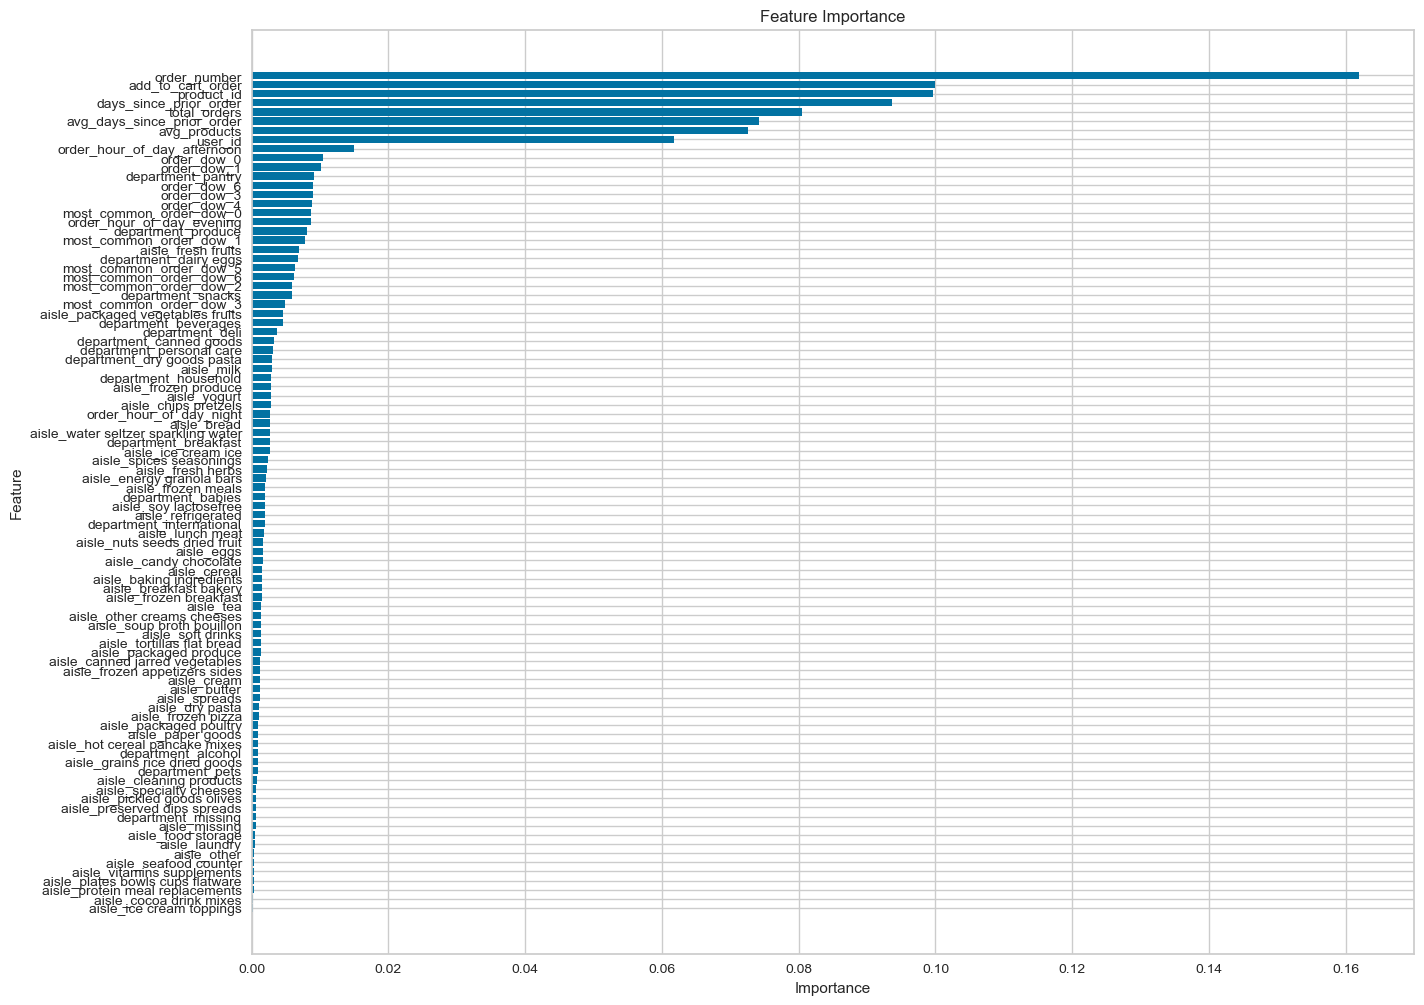

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()


### Select top 20 features and run RFECV 

In [34]:
top_20_features = feature_importance_df.head(20)

Top 12 features: ['order_number', 'add_to_cart_order', 'product_id', 'days_since_prior_order', 'total_orders', 'avg_days_since_prior_order', 'avg_products', 'user_id', 'order_hour_of_day_afternoon', 'order_dow_0', 'order_dow_1', 'department_pantry', 'order_dow_6']


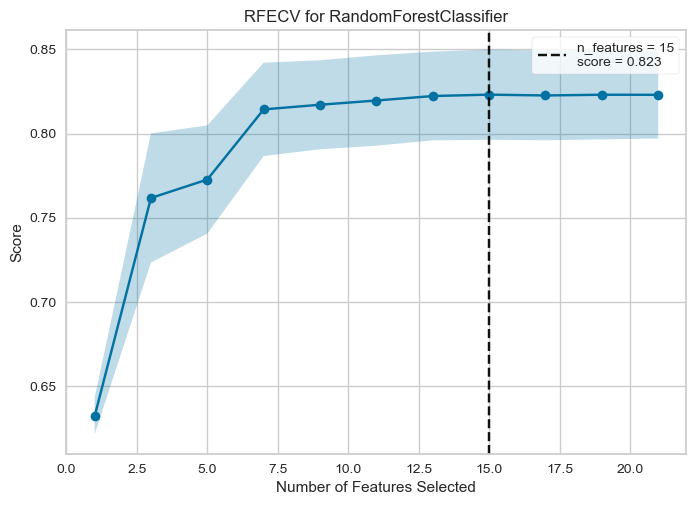

In [36]:
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestClassifier

selected_cols = top_20_features['Feature'].tolist()

visualizer = RFECV(RandomForestClassifier(), step=2, cv=3, n_jobs=-1)

# Fit the visualizer on the training data
visualizer.fit(X_train[selected_cols], y_train)

# Get the ranking of the features
ranking = visualizer.ranking_

top_12_idx = [i for i, x in enumerate(ranking) if x in range(1, 13)]
top_12_features = [selected_cols[i] for i in top_12_idx]
print("Top 12 features:", top_12_features[0:13])



visualizer.show()
plt.show()

The application of RFECV to our dataset reveals a distinct plateau in the feature importance plot at around 15 features.  
This indicates that beyond this point, additional features contribute minimally to the model's predictive power.   
Therefore, we will proceed with these 15 features for further modeling and analysis.

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
top_15_features=top_12_features[0:15]
X_train_selected = X_train[top_15_features]
model = RandomForestClassifier()
model.fit(X_train_selected, y_train)


# Transform X_val to include only the top 15 features
X_val_selected = X_val[top_15_features]

# Make predictions on the transformed validation set
y_pred = model.predict(X_val_selected)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.7541417054951557
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69     22506
           1       0.77      0.83      0.80     31578

    accuracy                           0.75     54084
   macro avg       0.75      0.74      0.74     54084
weighted avg       0.75      0.75      0.75     54084

Confusion Matrix:
 [[14728  7778]
 [ 5519 26059]]


In [38]:
X_test_selected = X_test[top_15_features]

Explained variance ratio: [0.17545128 0.10122431 0.08202259 0.07916083 0.07620964 0.07530062
 0.0671641  0.0666626  0.06622617 0.06526979 0.05497029 0.03144663
 0.02446001 0.02031564 0.01411551]
Cumulative explained variance: [0.17545128 0.27667559 0.35869817 0.437859   0.51406864 0.58936926
 0.65653336 0.72319596 0.78942213 0.85469192 0.90966221 0.94110884
 0.96556885 0.98588449 1.        ]
Number of components to retain for >90% variance: 11


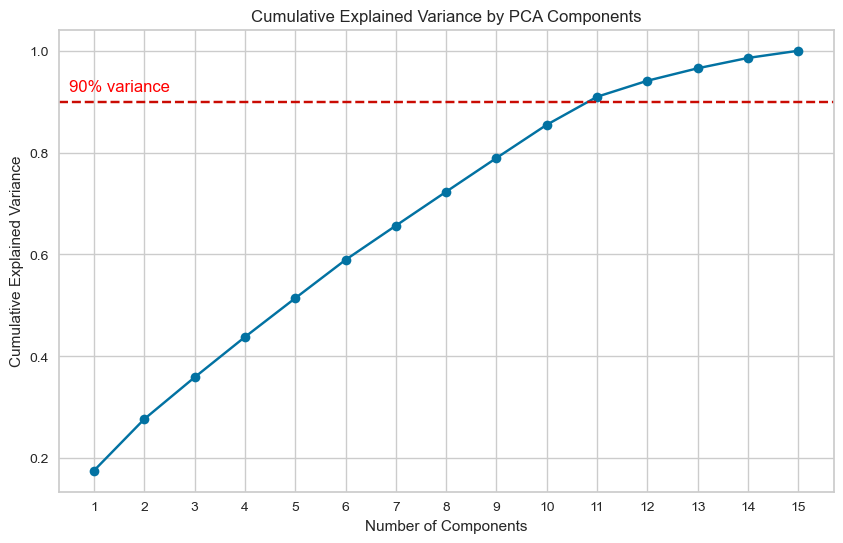

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

pca = PCA(n_components=15)

# Fit PCA on the standardized training data
X_train_pca = pca.fit_transform(X_train_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_variance)

n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain for >90% variance: {n_components}")
import matplotlib.pyplot as plt


# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.xticks(range(1, 16))
plt.axhline(y=0.90, color='r', linestyle='--')  # Add a horizontal line at 90% variance
plt.text(0.5, 0.92, '90% variance', color = 'red', fontsize=12)
plt.show()

Upon exploring PCA on all features, it was observed that the cumulative explained variance plot showed a linear trend without a plateau. This indicates that each principal component contributes similarly to the variance, suggesting no inherent lower-dimensional structure for effective dimensionality reduction. Given this, and the equal importance of original features, PCA may not offer substantial benefits for this dataset. Therefore, it has been decided not to use PCA and to explore alternative methods for feature selection and dimensionality reduction that better align with the data characteristics and analysis goals.

### Use X_train_selected, X_val_selected, X_test_selected to proceed on building the model.